# Main ABM Progress

*Setup from @rmaria del rio-chanona et al. 2021*
*Code: @ebbamark


In [1]:
# Import packages
from abm_funs import *
from scipy.interpolate import splrep, BSpline
import numpy as np
import pandas as pd
import random as random
import matplotlib.pyplot as plt
from pyabc.visualization import plot_kde_matrix
import math as math
from statistics import mode
from matplotlib.backends.backend_pdf import PdfPages
rng = np.random.default_rng()
test_fun()

path = "~/Documents/Documents - Nuff-Malham/GitHub/transition_abm/"

Function import successful


## Update for Stefi & Maria

Hi both,

Last we spoke, three of the items on my list were to:
- **Calibrate the model to real-world vacancy and unemployment rates using Approximate Bayesian Computation (ABC).** I have hit several snags with this but I think I am finally approaching something somewhat appropriate. See [Calibration Notebook]{https://github.com/ebbam/transition_abm/blob/a934316e223c4db7e2c57a33d350a6bba32bb560/code/calibration_us_abm.ipynb}. The below model results still use hand-selected paramaters (ie. not parameters systematically selected via ABC) as the calibration is still not returning satisfactory results likely due to the distance measure in ABC being incorrect. The hand-selected parameters used below replicate the dynamics of the vacancy and unemployment rate somewhat well. Will be updated as soon as the ABC is running well.
- **Identify data on past and/or forecast transition scenarios** both for out-of-sample validation and application to a transition scenario (following validation and calibration). I describe the current ideas in the [Overleaf]{https://www.overleaf.com/9347736945hkzqxrzfktwc#be706f}.
- **Get started on populating/organising the Overleaf.** In doing so, I came up with a few ideas regarding the issue of our application of the model. They are outlined in a bit more detail in the Overleaf. In brief though, Stefi and I discussed a structure that looks as follows:
    - Focus more closely either on the gender question or the long-term unemployment question:
        - I have a current preference for focusing on "long-term unemployment" as there is literature and data to draw from both from behav. labour economices but also labour economics more genearlly about the effect of unemployment duration on re-employment prospects (whether this comes from behavioural factors or not). Additionally, I have downloaded CPS Micro data in which I have access to the amount of time spent unemployed, search effort, and occupation of individuals. I am still trying to figure out how I can check whether disaggregating the first two variables by occupation leads to meaningful data. Furthermore, we can then fit quite nicely into the narratives around "left behind" populations as long-term unemployment is one of the main "fears" of an transition frictions (ie. what we want to avoid is people being unemployed too long and becoming discouraged or pessimistic about the future/green policy, etc.). I have plenty of Just Transition literature on the dangers of long-term unemployment for economic, mental, physical, and community health that we can draw on here to motivate the choice and the relevance/impact of such a research question. 
    - Calibrate economic and behavioural parameters of the model itself
    - Validate model's behaviour in relation to labour market inequalities (as we have already discussed around for example gender wage gaps and LTUER) but also potentially "out of sample" in relation to the 2008 financial crisis or covid, or just business cycle downturns in general
    - Once validated, move on to a "transition scenario" to evaluate the central concern we see to be feasible (whether that be gender, ltuer, or simply occupations being left behind).

    

### Data

#### US Model
Model constructed using 464 occupations from US Bureau of Labor Statistics (BLS) Data and IPUMS.
Data input from replication code in dRC et al 2021: https://zenodo.org/records/4453162. This data should be re-extracted. Perhaps incorporate econometric testing for transition probability/matrix calculations.

Additionally includes data on the gender share per occupation also from the BLS.


In [2]:
###################################
# US MODEL CONDITIONS AND DATA ####
###################################

# # Set preliminary parameters for delta_u, delta_v, and gamma 
# # - these reproduce somewhat acceptable Beveridge curves (especially in behavioural model) but were arrived at non-systematically
d_u_hat = 0.029
d_v_hat = 0.025
gamma_u = gamma_v = gamma = 0.1
bus_amp = 0.06

savenew = True
final = False

A = pd.read_csv(path+"dRC_Replication/data/occupational_mobility_network.csv", header=None)
employment = round(pd.read_csv(path+"dRC_Replication/data/ipums_employment_2016.csv", header = 0).iloc[:, [4]]/10000)
# Crude approximation using avg unemployment rate of ~5% - should aim for occupation-specific unemployment rates
unemployment = round(employment*(0.05/0.95))
# Less crude approximation using avg vacancy rate - should still aim for occupation-specific vacancy rates
vac_rate_base = pd.read_csv(path+"dRC_Replication/data/vacancy_rateDec2000.csv").iloc[:, 2].mean()/100
vacancies = round(employment*vac_rate_base/(1-vac_rate_base))
# Needs input data...
demand_target = employment + vacancies
wages = pd.read_csv(path+"dRC_Replication/data/ipums_variables.csv")[['median_earnings']]
gend_share = pd.read_csv(path+"data/ipums_variables_w_gender.csv")[['women_pct']]
mod_data =  {"A": A, "employment": employment, 
             'unemployment':unemployment, 'vacancies':vacancies, 
             'demand_target': demand_target, 'wages': wages, 'gend_share': gend_share}


### Initialise Network

In [3]:

net_temp, vacs = initialise(len(mod_data['A']), mod_data['employment'].to_numpy(), mod_data['unemployment'].to_numpy(), mod_data['vacancies'].to_numpy(), mod_data['demand_target'].to_numpy(), mod_data['A'], mod_data['wages'].to_numpy(), mod_data['gend_share'].to_numpy(), 0, 3)


#### Import parameters
The below uses hand-selected parameters that reasonably well replicate the UER and vacancy rates. Currently, these are better than those reutrned by the ABC calibration work. Willbe updated once ABC is finalised so that we can justify parameter choice with a more systematic search approach.

In [4]:
# The following are the input data to the function that runs the model.
#calib_params = pd.read_csv(path + "calibration/data/calibrated_params.csv") # Import calibrated parameters

parameters = {'mod_data': mod_data, # mod_data: occupation-level input data (ie. employment/uneployment levels, wages, gender ratio, etc.).
     'net_temp': net_temp, # net_temp: occupational network
     'vacs': vacs, # list of available vacancies in the economy
     'behav_spec': False, # whether or not to enable behavioural element or not (boolean value)
     'time_steps': 300, # number of time steps to iterate the model - for now always exclude ~50 time steps for the model to reach a steady-state
     'd_u': d_u_hat, # del_u: spontaneous separation rate
     'd_v': d_v_hat, # del_v: spontaneous vacancy rate
     'gamma': gamma, # gamma: "speed" of adjustment to target demand of vacancies and unemployment
     'bus_amp': bus_amp,
     'bus_cycle_len': 160, # bus_cycle_len: length of typical business cycle (160 months as explained above)
     'delay': 80} # delay: number of time steps to exclude from calibration sample to allow model to reach steady state and expansion phase of business cycle - this is certainly inefficient and should be changed.


# The following line runs one base example of the model itself with the hand-picked parameters outlined above. 
# Run model without behavioural spec
rec = run_single_local(**parameters)

params_behav = parameters.copy()
params_behav.update({'behav_spec': True,
                   'd_u': 0.016,
                   'd_v': 0.01,
                   'gamma': 0.13,
                   'bus_amp': 0.05})


rec_behav = run_single_local(**params_behav)

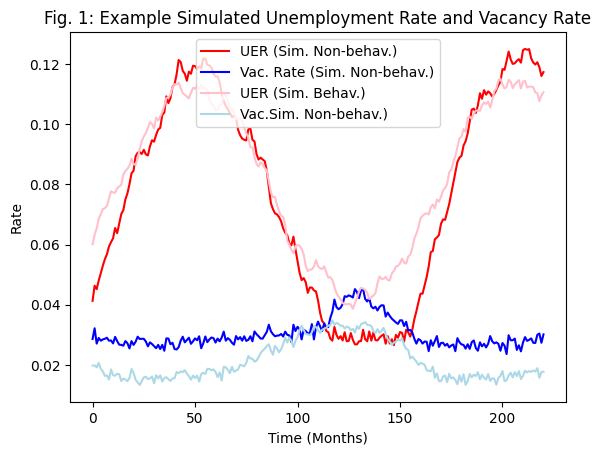

In [5]:
plt.plot(rec['UER'], color = "red", label = "UER (Sim. Non-behav.)")
plt.plot(rec['VACRATE'], color = "blue", label = "Vac. Rate (Sim. Non-behav.)")
plt.plot(rec_behav['UER'], color = "pink", label = "UER (Sim. Behav.)")
plt.plot(rec_behav['VACRATE'], color = "lightblue", label = "Vac.Sim. Non-behav.)")
plt.title("Fig. 1: Example Simulated Unemployment Rate and Vacancy Rate")
leg = plt.legend(loc='upper center')
plt.ylabel("Rate")
plt.xlabel("Time (Months)")
plt.show()

## Model Run

### Initialise network & run behavioural and non-behavioural model


In [6]:
parameters.pop('delay', None)
parameters.update({'runs': 25})

sim_record_f_all, net_nonbehav, net_nonbehav_list = run_sim(**parameters)


In [7]:
params_behav.pop('delay', None)
params_behav.update({'runs': 25})

sim_record_t_all, net_behav, net_behav_list = run_sim(**params_behav)

# Results

Below I present the results from a model run over 300 time steps. 

## Beveridge curve validation

Colour of the below plots go from purple to yellow as time increases. Again, these are hand-selected parameters (ie. not taken from ABC calibration). The parameters for the behavioural model match the historical data (in grey) much better than the non-behavioural model. I think the matching process between vacancies and unemployed persons is too quick/non-frictional in the non-behavioural model causing this behaviour. But I am not yet sure...

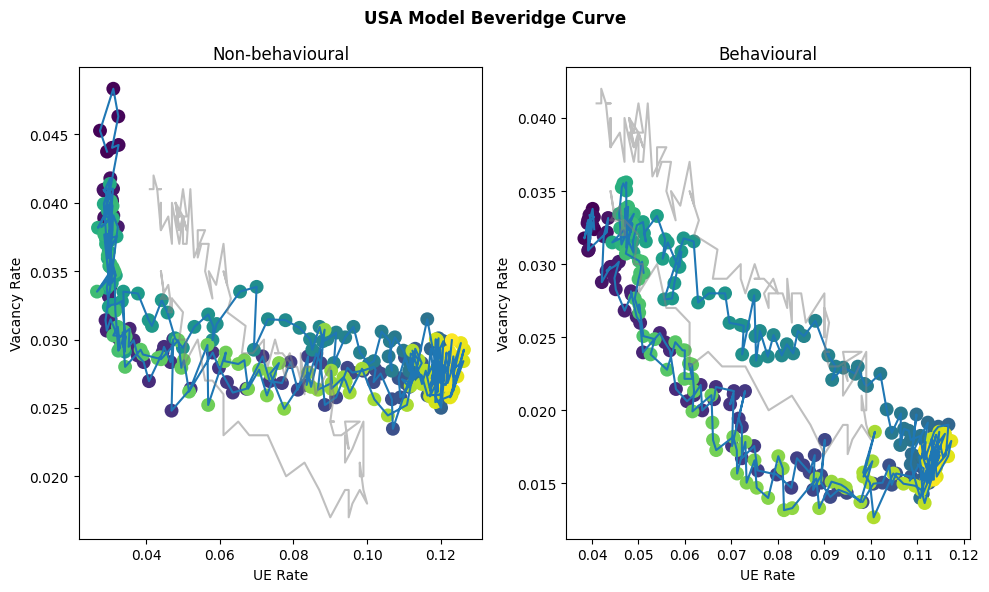

In [8]:
# Summary values for one run 
sim_record_t = pd.DataFrame(np.transpose(np.hstack(sim_record_t_all)))
sim_record_t.columns =['Sim', 'Time Step', 'Employment', 'Unemployment', 'Workers', 'Vacancies', 'LT Unemployed Persons', 'Target_Demand']
sim_record_f = pd.DataFrame(np.transpose(np.hstack(sim_record_f_all)))
sim_record_f.columns =['Sim', 'Time Step', 'Employment', 'Unemployment', 'Workers', 'Vacancies', 'LT Unemployed Persons', 'Target_Demand']

record1_t = sim_record_t[(sim_record_t['Sim'] == 0)].groupby(['Sim', 'Time Step']).sum().reset_index()
record1_f = sim_record_f[(sim_record_f['Sim'] == 0)].groupby(['Sim', 'Time Step']).sum().reset_index()

end_t = record1_t[(record1_t['Time Step'] == parameters['time_steps'])]
end_f = record1_f[(record1_f['Time Step'] == parameters['time_steps'])]

unrate = pd.read_csv(path+"data/macro_vars/UNRATE.csv", delimiter=',', decimal='.')
unrate["DATE"] = pd.to_datetime(unrate["DATE"])
unrate["UER"] = unrate['UNRATE']/100
unrate['FD_UNRATE'] = pd.Series(unrate['UER']).diff()

# Monthly, seasonally adjusted job openings rate (total nonfarm)
# Source: https://fred.stlouisfed.org/series/JTSJOR

jorate = pd.read_csv(path+"data/macro_vars/JTSJOR.csv", delimiter=',', decimal='.')
jorate["DATE"] = pd.to_datetime(jorate["DATE"])
jorate["VACRATE"] = jorate['JTSJOR']/100
jorate['FD_VACRATE'] = pd.Series(jorate['VACRATE']).diff()

macro_observations = pd.merge(unrate, jorate, how = 'outer', on = 'DATE')
macro_abbrev = macro_observations.loc[(macro_observations['DATE'] >= "2006-12-01") & (macro_observations['DATE'] <= "2017-12-01")].reset_index()

ue_vac_f = record1_f.loc[:,['Workers', 'Unemployment', 'Vacancies', 'Target_Demand']]
ue_vac_f['UE Rate'] = ue_vac_f['Unemployment'] / ue_vac_f['Workers']
ue_vac_f['Vac Rate'] = ue_vac_f['Vacancies'] / ue_vac_f['Target_Demand']
ue_vac_f = ue_vac_f[46:]

ue_vac_t = record1_t.loc[:,['Workers', 'Unemployment', 'Vacancies', 'Target_Demand']]
ue_vac_t['UE Rate'] = ue_vac_t['Unemployment'] / ue_vac_t['Workers']
ue_vac_t['Vac Rate'] = ue_vac_t['Vacancies'] / ue_vac_t['Target_Demand']
ue_vac_t = ue_vac_t[46:]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

ax1.plot(ue_vac_f['UE Rate'], ue_vac_f['Vac Rate'])
ax1.scatter(ue_vac_f['UE Rate'], ue_vac_f['Vac Rate'], c=ue_vac_f.index, s=100, lw=0)
ax1.plot(macro_abbrev['UER'],macro_abbrev['VACRATE'], c = "grey", alpha = 0.5)
ax1.set_title("Non-behavioural")
ax1.set_xlabel("UE Rate")
ax1.set_ylabel("Vacancy Rate")

ax2.plot(ue_vac_t['UE Rate'], ue_vac_t['Vac Rate'])
ax2.set_title("Behavioural")
ax2.scatter(ue_vac_t['UE Rate'], ue_vac_t['Vac Rate'], c=ue_vac_t.index, s=100, lw=0) 
ax2.plot(macro_abbrev['UER'],macro_abbrev['VACRATE'], c = "grey", alpha = 0.5)
ax2.set_xlabel("UE Rate")
ax2.set_ylabel("Vacancy Rate")

    
fig.suptitle("USA Model Beveridge Curve", fontweight = 'bold')
fig.tight_layout()


#plt.savefig('../output/usa/beveridge_behav_0_1_all.jpg', dpi = 300)
plt.show()
plt.close()



## Gender Wage Gaps

I have incorporated data about the gender shares into the initialisation function of the network from the Bureau of Labour Statistics [Current Population Survey](https://www.bls.gov/cps/cpsaat11.htm). Occupations are populated with employed and unemployed workers in line with each occupation's gender shares in the initialise function. 

The plots immediately below show (from left to right): initialised network (the return value of initialise); steady state behaviour of non-behavioural model; steady state behaviour of behavioural model.

Some things to note:
- **The gender wage gap below is not corrected for occupational choice** (rather it is almost entirely a result of occupational choice by design). The 13% gender wage gap in the initialised model (before model run) is in line with US gender wage gaps not corrected for occupational choice (Good!).      

- **However, the steady-state behaviour of the behavioural model leads to the exacerbation of this gender wage gap (38% wage gape).** I have played aronud with the risk aversion parameter to see what might be causing this issue and found that the wage gap is exacerbated even when we do not vary the risk aversion between men and women. Rather simply occupational connectedness (and therfore wage options) seems to exacerbate the wage gap. Furthermore, the ratio of female:male risk aversion should be less than 1 as the model is currently constructed which is not "in line" with evidence. Might be a function of model choice, but I think it points more to where women are concentrated in the occupational network. 

Gender Distribution Data from 2022
https://www.neilsberg.com/research/datasets/2445ffc0-981b-11ee-99cf-3860777c1fe6/
American Community Survey aggregated and distributed by Neilsberg

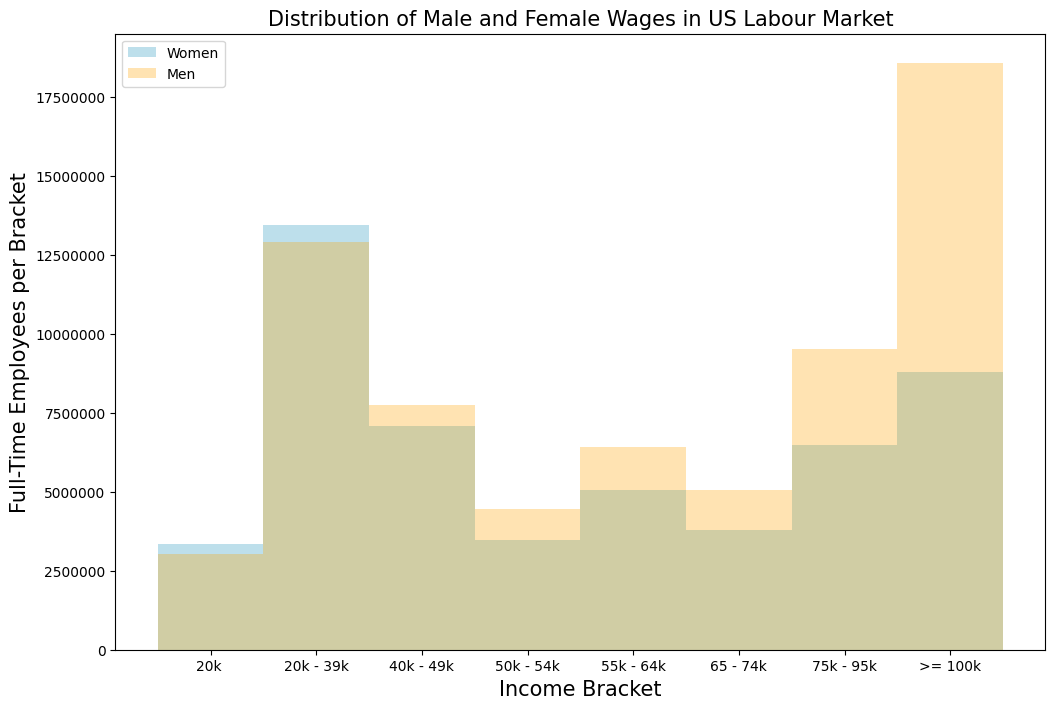

61354.82019159919


69250.7515119483

In [9]:
gender_income = pd.read_csv(path+"data/gender_income_distribution_usa_2022.csv", delimiter=',', thousands = ",")

gender_income['Income Bracket'] = gender_income['Income Bracket'].str.replace(' or loss', '')
gender_income['Income Bracket'] = gender_income['Income Bracket'].str.replace(' or more', '')
gender_income['Ceiling'] = gender_income['Income Bracket'].str[-7:]
gender_income['Ceiling'] = gender_income['Ceiling'].str.replace(',', '')
gender_income['Ceiling'] = gender_income['Ceiling'].str.replace('$', '')
gender_income['Ceiling'] = gender_income['Ceiling'].str.replace(' ', '')
gender_income['Ceiling'] = gender_income['Ceiling'].astype('Int64')
gender_income.loc[0:7, 'Bracket'] = "20k "
gender_income.loc[8:12, 'Bracket'] = "20k - 39k"
gender_income.loc[13:14, 'Bracket'] = "40k - 49k"
gender_income.loc[15, 'Bracket'] = "50k - 54k"
gender_income.loc[16, 'Bracket'] = "55k - 64k"
gender_income.loc[17, 'Bracket'] = "65 - 74k"
gender_income.loc[18, 'Bracket'] = "75k - 95k"
gender_income.loc[19, 'Bracket'] = ">= 100k"
brackets = gender_income.groupby(['Bracket']).sum().reset_index()

barWidth = 1
fig = plt.subplots(figsize =(12, 8)) 
br1 = np.arange(len(brackets['Bracket'])) + 1
br2 = br1
 
# Make the plot
plt.bar(br1, brackets['Full-Time Females'], color ='lightblue', width = barWidth, alpha = 0.8,
         label ='Women') 
plt.bar(br2, brackets['Full-Time Males'], color ='orange', width = barWidth, alpha = 0.3,
        label ='Men') 


# Adding Xticks 
plt.xlabel('Income Bracket', fontsize = 15) 
plt.ylabel('Full-Time Employees per Bracket', fontsize = 15) 
plt.ticklabel_format(useOffset=False, style='plain')
plt.xticks([r + barWidth for r in range(len(brackets['Bracket']))], 
        brackets['Bracket'])

plt.title('Distribution of Male and Female Wages in US Labour Market', fontsize = 15) 
plt.legend()
plt.show() 

womens_wage = (gender_income['Ceiling'] * gender_income['Full-Time Females']).sum()/(gender_income['Full-Time Females'].sum())
mens_wage = (gender_income['Ceiling'] * gender_income['Full-Time Males']).sum()/(gender_income['Full-Time Males'].sum())

print(womens_wage)
mens_wage

--------------------
--------------------
0
322991
1
325682


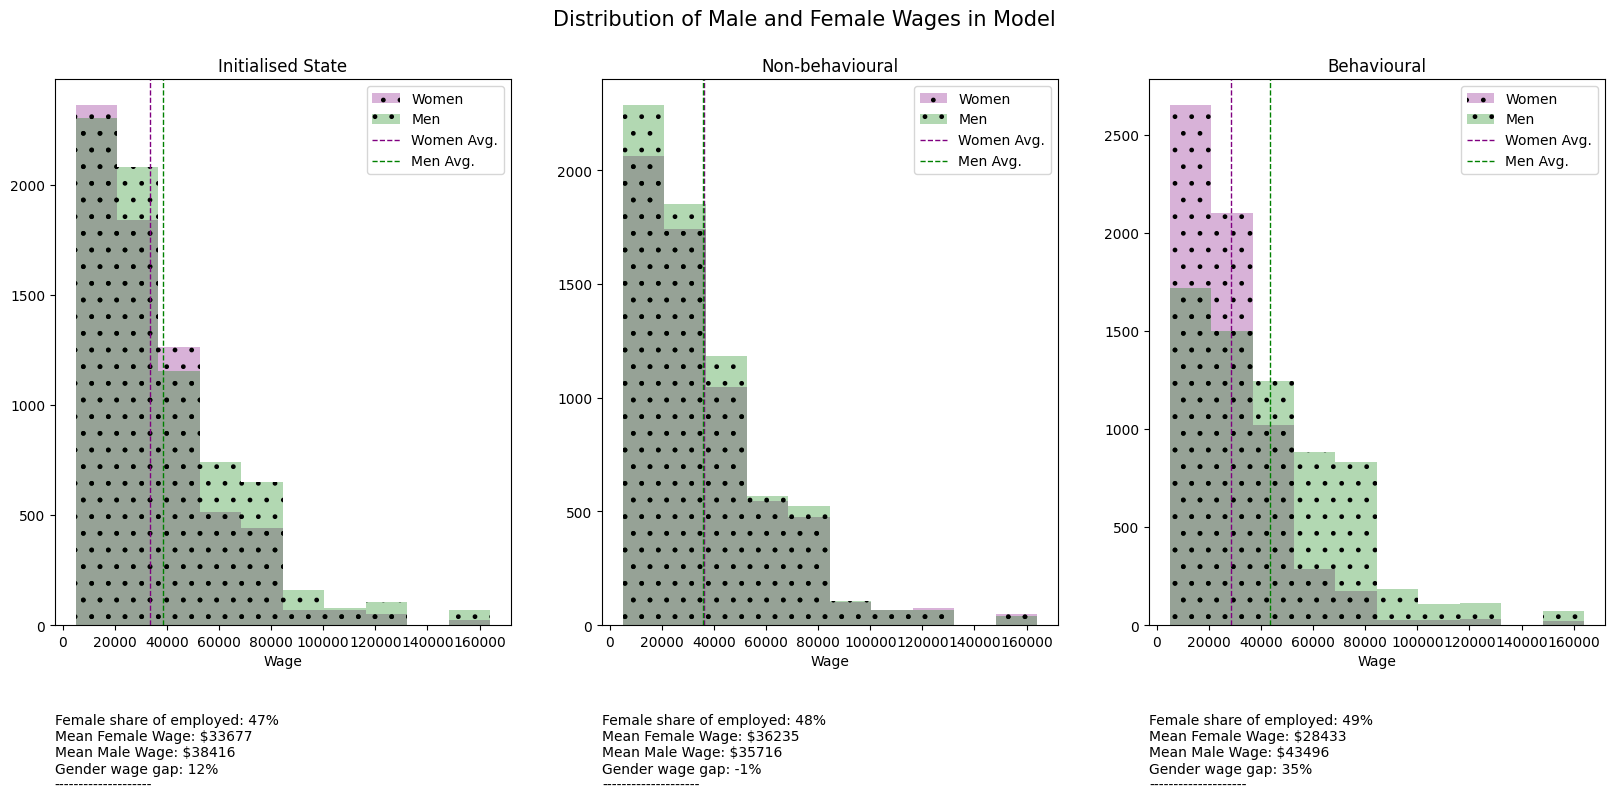

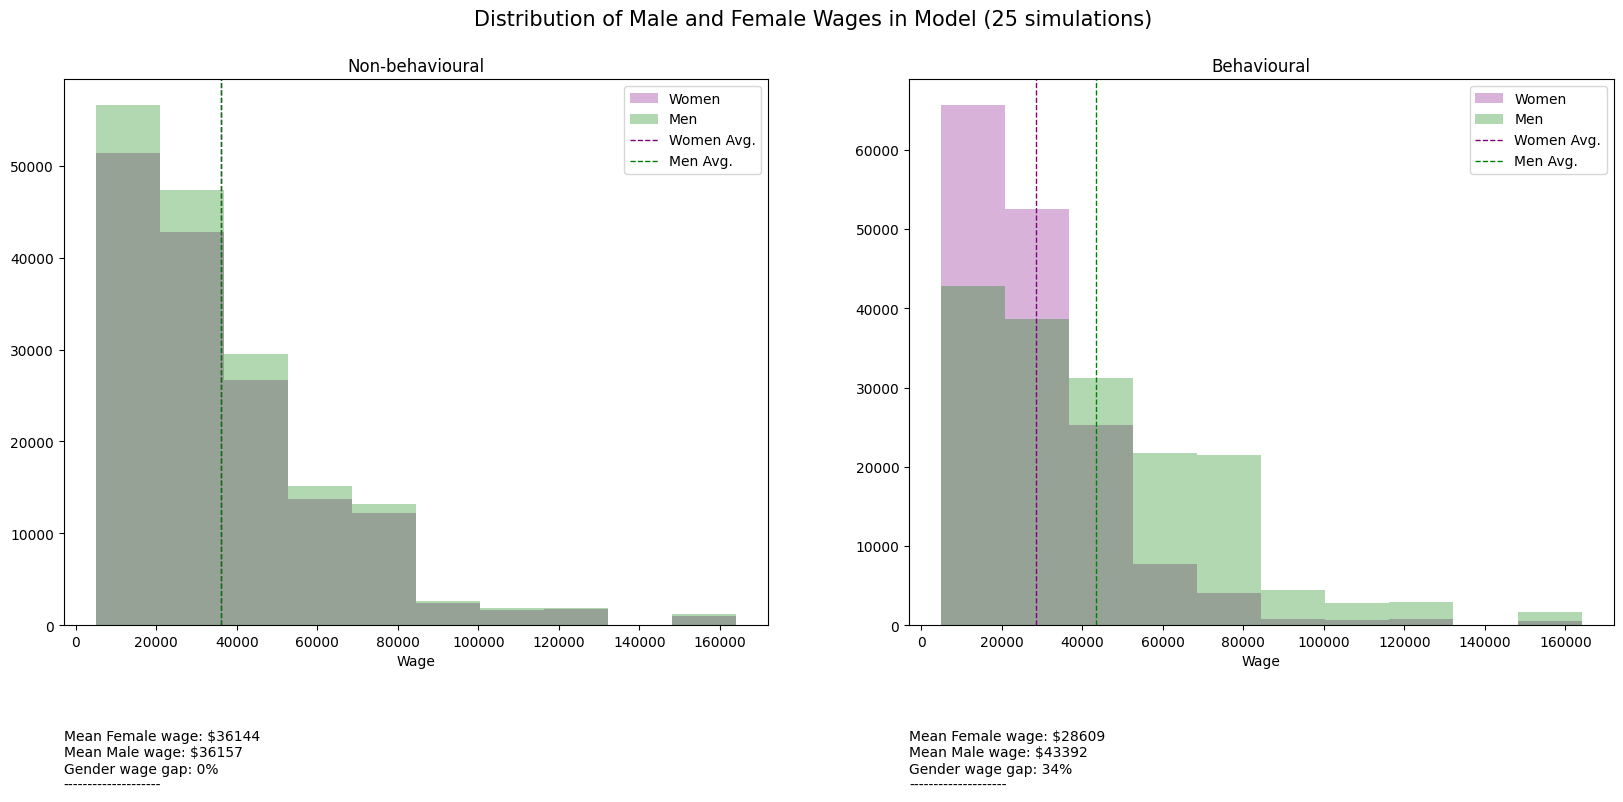

In [10]:
# # Confirm a wage gap in the init state and behavioural models! A little high in the behavioural model...and 0 in the non-behavioural....
fig, ax = plt.subplots(1, 3, figsize=(20, 7))
print("--------------------")
for i, k in enumerate([net_temp, net_nonbehav, net_behav]):
    emp_counter = 0
    women = 0
    men = 0

    w_wages = []
    m_wages = []

    w_wage = 0
    m_wage = 0

    for occ in k:
        emp_counter += len(occ.list_of_employed)
        women += len([wrkr for wrkr in occ.list_of_employed if wrkr.female])
        men += len([wrkr for wrkr in occ.list_of_employed if not(wrkr.female)])
        w_wages.extend([wrkr.wage for wrkr in occ.list_of_employed if wrkr.female])
        m_wages.extend([wrkr.wage for wrkr in occ.list_of_employed if not(wrkr.female)])
        w_wage += sum([wrkr.wage for wrkr in occ.list_of_employed if wrkr.female])
        m_wage += sum([wrkr.wage for wrkr in occ.list_of_employed if not(wrkr.female)])
    
        
    t= " \n" + " \n" + "Female share of employed: " + str(round((women/emp_counter)*100)) + "% \n" + "Mean Female Wage: $" + str(round(w_wage/women)) + "\n" + "Mean Male Wage: $" + str(round(m_wage/men)) + "\n" + "Gender wage gap: " + str(round(100*(1 - (w_wage/women)/(m_wage/men)))) + "%" + "\n" + "--------------------"

    n_bins = 10
    women = np.array(w_wages)
    men = np.array(m_wages)

    # We can set the number of bins with the *bins* keyword argument.
    ax[i].hist(women, bins=n_bins, alpha = 0.3, color = 'purple', label = 'Women', fill = True, hatch = '.')
    ax[i].hist(men, bins=n_bins, alpha = 0.3, label = 'Men', color = 'green', fill = True, hatch = '.')  
    ax[i].axvline(women.mean(), color='purple', linestyle='dashed', linewidth=1, label = 'Women Avg.')
    ax[i].axvline(men.mean(), color='green', linestyle='dashed', linewidth=1, label = 'Men Avg.')
    ax[i].legend(loc='upper right') 
    ax[i].annotate(t, xy = (0, -0.3), xycoords='axes fraction')
    ax[0].set_title('Initialised State')
    ax[1].set_title('Non-behavioural')
    ax[2].set_title('Behavioural')  
    ax[0].set_xlabel('Wage')
    ax[1].set_xlabel('Wage')
    ax[2].set_xlabel('Wage')  

    
fig.suptitle('Distribution of Male and Female Wages in Model', fontsize = 15) 
fig.subplots_adjust(bottom=0.1)

#if final:
plt.savefig('../output/usa/wage_gaps.jpg', dpi = 300)
#else:
 #   plt.show()
#plt.close()


## All simulations
fig, ax = plt.subplots(1, 2, figsize=(20, 7))
print("--------------------")
for i, lst in enumerate([net_nonbehav_list, net_behav_list]):
    print(i)
    emp_counter = 0
    women = 0
    men = 0

    w_wages = []
    m_wages = []

    w_wage = 0
    m_wage = 0
    for net_l in lst:
        for occ in net_l:
            emp_counter += len(occ.list_of_employed)
            women += len([wrkr for wrkr in occ.list_of_employed if wrkr.female])
            men += len([wrkr for wrkr in occ.list_of_employed if not(wrkr.female)])
            w_wages.extend([wrkr.wage for wrkr in occ.list_of_employed if wrkr.female])
            m_wages.extend([wrkr.wage for wrkr in occ.list_of_employed if not(wrkr.female)])
            w_wage += sum([wrkr.wage for wrkr in occ.list_of_employed if wrkr.female])
            m_wage += sum([wrkr.wage for wrkr in occ.list_of_employed if not(wrkr.female)])

    print(emp_counter)
    t= " \n" + " \n" + "Mean Female wage: $" + str(round(w_wage/women)) + "\n" + "Mean Male wage: $" + str(round(m_wage/men)) + "\n" + "Gender wage gap: " + str(round(100*(1 - (w_wage/women)/(m_wage/men)))) + "%" + "\n" + "--------------------"

    n_bins = 10
    women = np.array(w_wages)
    men = np.array(m_wages)

    # We can set the number of bins with the *bins* keyword argument.
    ax[i].hist(women, bins=n_bins, alpha = 0.3, color = 'purple', label = 'Women')
    ax[i].hist(men, bins=n_bins, alpha = 0.3, color = 'green', label = 'Men')  
    ax[i].axvline(women.mean(), color='purple', linestyle='dashed', linewidth=1, label = 'Women Avg.')
    ax[i].axvline(men.mean(), color='green', linestyle='dashed', linewidth=1, label = 'Men Avg.')
    ax[i].legend(loc='upper right') 
    ax[i].annotate(t, xy = (0, -0.3), xycoords='axes fraction')
    ax[0].set_title('Non-behavioural')
    ax[1].set_title('Behavioural')  
    ax[i].set_xlabel('Wage')
fig.suptitle('Distribution of Male and Female Wages in Model ('+str(parameters['runs'])+' simulations)', fontsize = 15) 
fig.subplots_adjust(bottom=0.1)

#if final:
plt.savefig('../output/usa/wage_gaps_sim_100.jpg', dpi = 300)
#else:
#    plt.show()
#plt.close()


## LTUER

The following plot shows the distribution of time spent unemployed for workers in the US economy. From top to bottom: initialised network (the return value of initialise); steady state behaviour of non-behavioural model; steady state behaviour of behavioural model. Left-hand panels show the distribution for workers overall; right-hand panel shows the overlapping distributions for men and women. The graphs share an x-axis to be able to compare the distribution across models.

Takeaways: 

- **The behavioural model evidently leads to a longer tail of long-term unemployment in the steady state model.** This is exactly the result we wanted to see.
- **Men tend to have a longer tail than women in the behavioural model.** I will investigate whether this could be because of occupational differences or rather a symptom of the fact that they "aim higher" when applying to vacancies. 

These resuls have yet to be thoroughly tested and indeed calibration remains to be done. But for now, promising support for our hypothesis that behavioural mechanisms (search effort and heterogeneous preferences across genders) lead to different behaviours and might 'contribute' to the real-world long tail of long-term unemployment rate.


LTUER Distribution from BLS
https://www.bls.gov/news.release/empsit.t12.htm

  NUMBER OF UNEMPLOYED  Unnamed: 1  Min  Max    No        Dist  Repeat
0    Less than 5 weeks         NaN    0    4  1909  477.250000       4
1        5 to 14 weeks         NaN    5   14  2141  237.888889       9
2       15 to 26 weeks         NaN   15   26  1195  108.636364      11
3    27 weeks and over         NaN   27  150  1359   11.048780     123


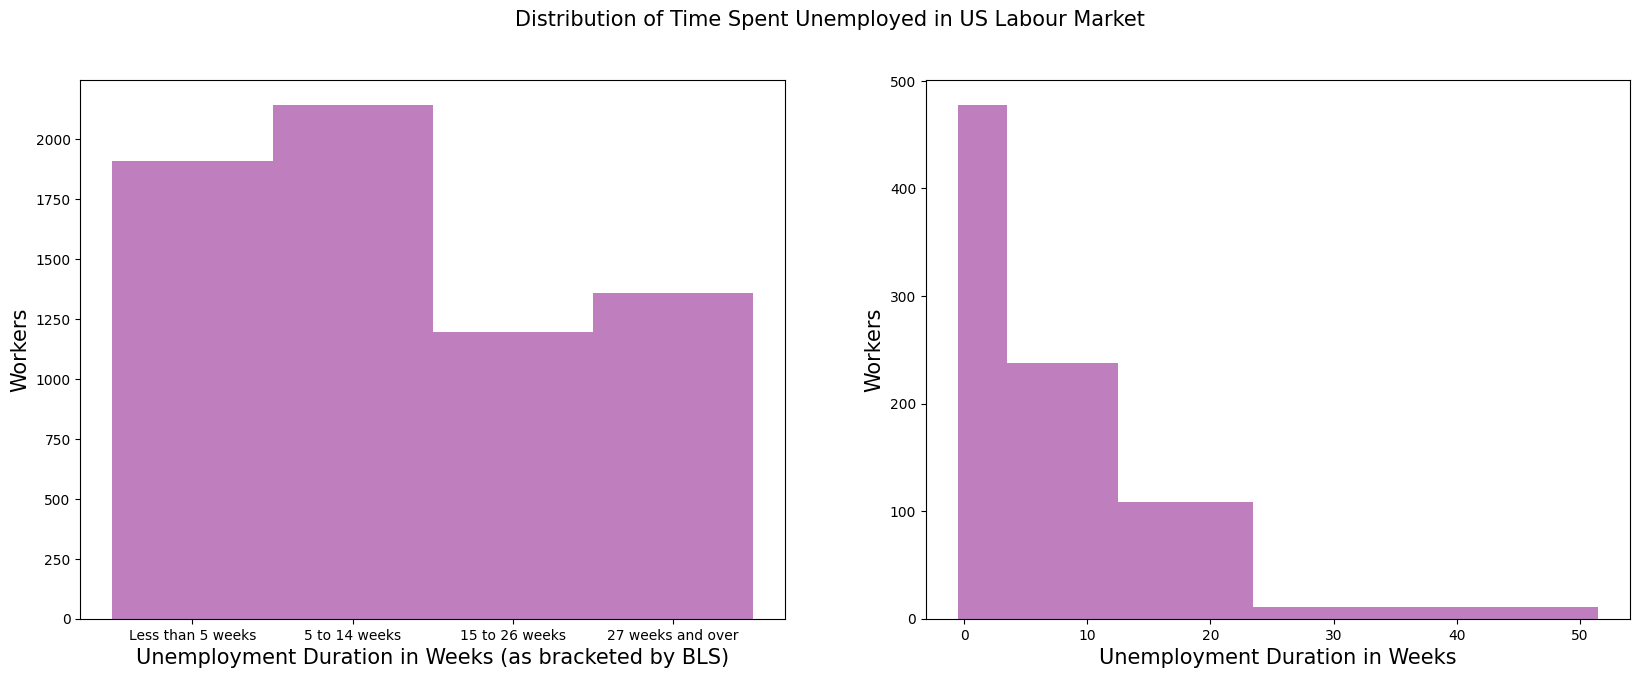

In [11]:
ltuer = pd.read_csv(path+"data/ltuer_april_2023.csv", delimiter=';', thousands = ",")

ltuer['Dist'] = ltuer['No']/(ltuer['Max'] - ltuer['Min'])
ltuer['Repeat'] = ltuer['Max'] - ltuer['Min']
print(ltuer)

# Sample data
data = {'Value_to_repeat': ltuer['Dist'],
        'Repeat_times': ltuer['Repeat']}

# Create a DataFrame
df = pd.DataFrame(data)

# Create a new DataFrame with repeated values
df_repeated = pd.DataFrame({
    'No Workers': df['Value_to_repeat'].repeat(df['Repeat_times']),
    'Original_Index': df.index.repeat(df['Repeat_times'])
})

# Reset the index if needed
df_repeated.reset_index(drop=True, inplace=True)
df_short = df_repeated[0:52]

fig, ax = plt.subplots(1, 2, figsize=(20, 7))
barWidth = 1
 
# Make the plot
ax[1].bar(df_short.index, df_short['No Workers'], color ='purple', width = barWidth, alpha = 0.5) 

# Adding Xticks 
ax[1].set_xlabel('Unemployment Duration in Weeks', fontsize = 15) 
ax[1].set_ylabel('Workers', fontsize = 15) 
#ax[1].set_ticklabel_format(useOffset=False, style='plain')
#ax[1].set_xticks([r + barWidth for r in range(len(brackets['Bracket']))], 
#      brackets['Bracket'])
 
# Make the plot
ax[0].bar(ltuer['NUMBER OF UNEMPLOYED'], ltuer['No'], color ='purple', width = barWidth, alpha = 0.5) 

# Adding Xticks 
ax[0].set_xlabel('Unemployment Duration in Weeks (as bracketed by BLS)', fontsize = 15) 
ax[0].set_ylabel('Workers', fontsize = 15) 
#ax[0].ticklabel_format(useOffset=False, style='plain')
#ax[0].xticks([r + barWidth for r in range(len(brackets['Bracket']))], 
 #       brackets['Bracket'])
 
fig.suptitle('Distribution of Time Spent Unemployed in US Labour Market', fontsize = 15) 
plt.show() 


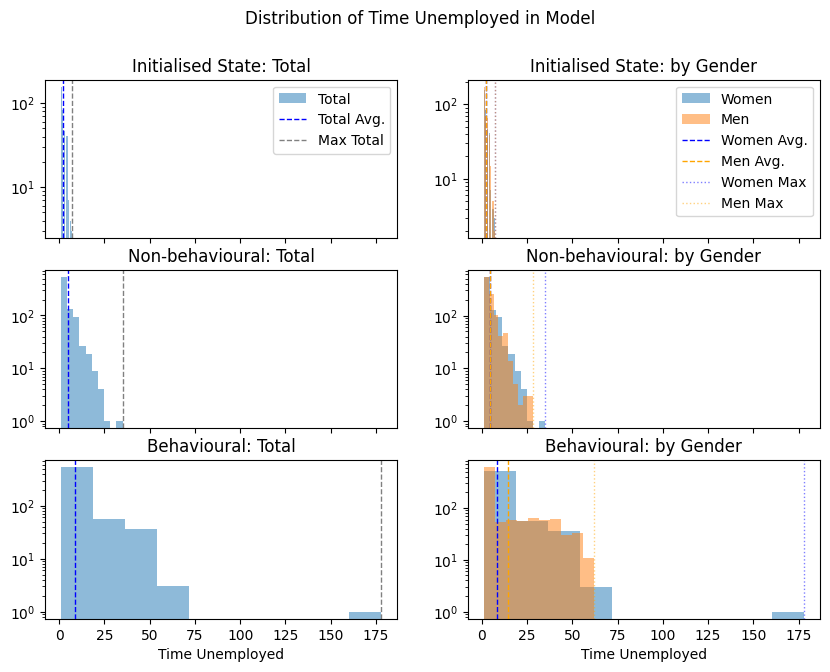

--------------------


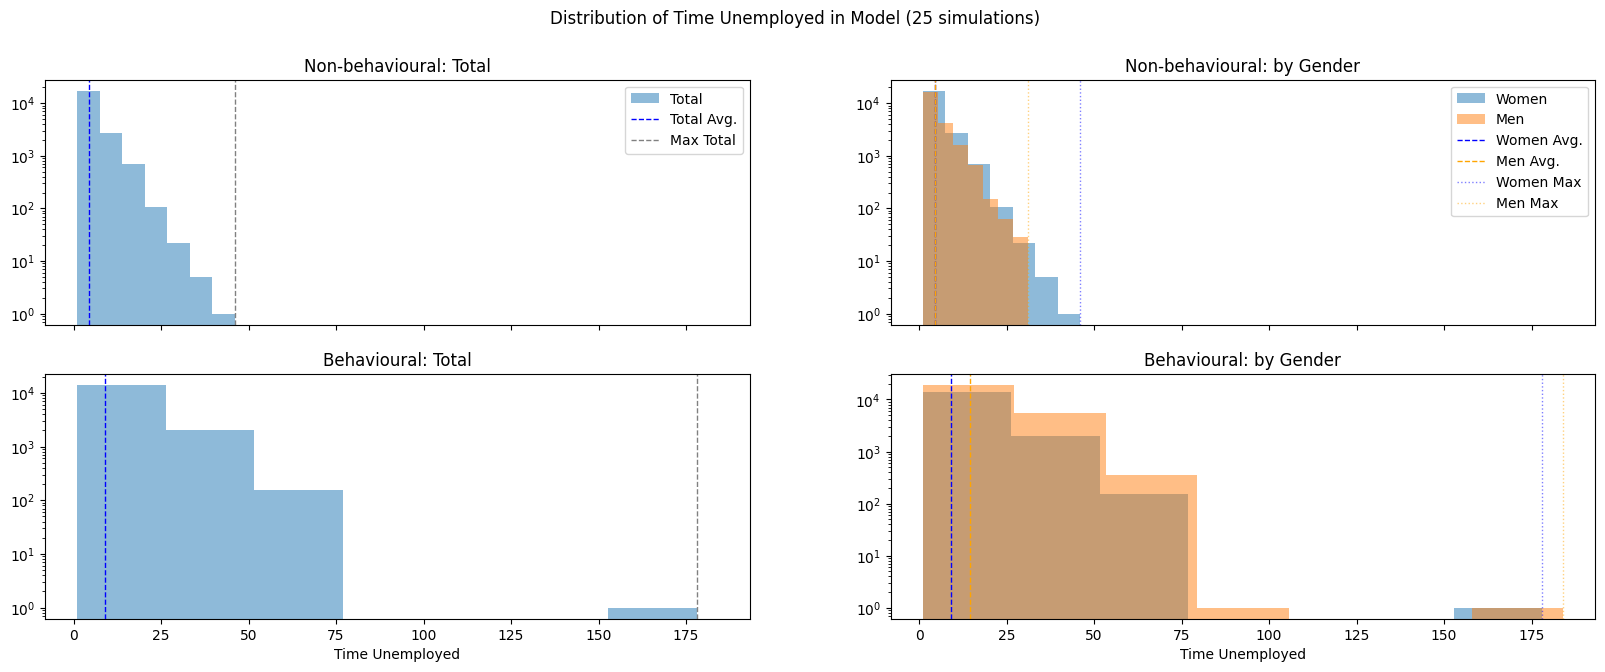

In [12]:
fig, ax = plt.subplots(3, 2, figsize=(10, 7), sharex = True)

for i, k in enumerate([net_temp, net_nonbehav, net_behav]):
    w_time_unemp = []
    m_time_unemp = []

    for occ in k:
        w_time_unemp.extend([wrkr.time_unemployed for wrkr in occ.list_of_unemployed if wrkr.female])
        m_time_unemp.extend([wrkr.time_unemployed for wrkr in occ.list_of_unemployed if not(wrkr.female)])

    women = np.array(w_time_unemp)
    men = np.array(m_time_unemp)
    total = np.array(w_time_unemp)
    n_bins = 10

    # We can set the number of bins with the *bins* keyword argument.
    ax[i,0].hist(total, bins=n_bins, alpha = 0.5, label = 'Total')
    ax[i,0].axvline(total.mean(), color='blue', linestyle='dashed', linewidth=1, label = 'Total Avg.')
    ax[i,0].axvline(total.max(), color='grey', linestyle='dashed', linewidth=1, label = 'Max Total')
    ax[0,0].legend(loc='upper right') 
    ax[0,0].set_title('Non-behavioural')
    ax[1,0].set_title('Behavioural')  
    
    ax[i,1].hist(women, bins=n_bins, alpha = 0.5, label = 'Women')
    ax[i,1].hist(men, bins=n_bins, alpha = 0.5, label = 'Men')  
    ax[i,1].axvline(women.mean(), color='blue', linestyle='dashed', linewidth=1, label = 'Women Avg.')
    ax[i,1].axvline(men.mean(), color='orange', linestyle='dashed', linewidth=1, label = 'Men Avg.')
    ax[i,1].axvline(women.max(), color='blue', alpha = 0.5, linestyle='dotted', linewidth=1, label = 'Women Max')
    ax[i,1].axvline(men.max(), color='orange', alpha = 0.5, linestyle='dotted', linewidth=1, label = 'Men Max')
    ax[0,1].legend(loc='upper right')
    ax[0,0].set_title('Initialised State: Total')
    ax[0,1].set_title('Initialised State: by Gender')
    ax[1,0].set_title('Non-behavioural: Total')
    ax[1,1].set_title('Non-behavioural: by Gender')
    ax[2,0].set_title('Behavioural: Total')  
    ax[2,1].set_title('Behavioural: by Gender')
    ax[2,0].set_xlabel("Time Unemployed")
    ax[2,1].set_xlabel("Time Unemployed")
    
    ax[i,0].set_yscale("log")
    ax[i,1].set_yscale("log")

fig.suptitle('Distribution of Time Unemployed in Model') 
if final:
    plt.savefig('../output/usa/ltuer_distributions.jpg', dpi = 300)
else:
    plt.show()
plt.close()

## All simulations
fig, ax = plt.subplots(2, 2, figsize=(20, 7), sharex = True)
print("--------------------")
for i, lst in enumerate([net_nonbehav_list, net_behav_list]):
    w_time_unemp = []
    m_time_unemp = []
    for net_l in lst:
        for occ in net_l:
            w_time_unemp.extend([wrkr.time_unemployed for wrkr in occ.list_of_unemployed if wrkr.female])
            m_time_unemp.extend([wrkr.time_unemployed for wrkr in occ.list_of_unemployed if not(wrkr.female)])

    women = np.array(w_time_unemp)
    men = np.array(m_time_unemp)
    total = np.array(w_time_unemp)
    n_bins = 7

    # We can set the number of bins with the *bins* keyword argument.
    ax[i,0].hist(total, bins=n_bins, alpha = 0.5, label = 'Total')
    ax[i,0].axvline(total.mean(), color='blue', linestyle='dashed', linewidth=1, label = 'Total Avg.')
    ax[i,0].axvline(total.max(), color='grey', linestyle='dashed', linewidth=1, label = 'Max Total')
    ax[0,0].legend(loc='upper right') 
    ax[0,0].set_title('Non-behavioural')
    ax[1,0].set_title('Behavioural')  
    
    ax[i,1].hist(women, bins=n_bins, alpha = 0.5, label = 'Women')
    ax[i,1].hist(men, bins=n_bins, alpha = 0.5, label = 'Men')  
    ax[i,1].axvline(women.mean(), color='blue', linestyle='dashed', linewidth=1, label = 'Women Avg.')
    ax[i,1].axvline(men.mean(), color='orange', linestyle='dashed', linewidth=1, label = 'Men Avg.')
    ax[i,1].axvline(women.max(), color='blue', alpha = 0.5, linestyle='dotted', linewidth=1, label = 'Women Max')
    ax[i,1].axvline(men.max(), color='orange', alpha = 0.5, linestyle='dotted', linewidth=1, label = 'Men Max')
    ax[0,1].legend(loc='upper right')
    ax[0,0].set_title('Non-behavioural: Total')
    ax[0,1].set_title('Non-behavioural: by Gender')
    ax[1,0].set_title('Behavioural: Total')  
    ax[1,1].set_title('Behavioural: by Gender')
    ax[1,0].set_xlabel("Time Unemployed")
    ax[1,1].set_xlabel("Time Unemployed")
    ax[i,0].set_yscale("log")
    ax[i,1].set_yscale("log")
    #ax[i,0].set_yticklabels_format(useOffset=False, style='plain')
fig.suptitle('Distribution of Time Unemployed in Model ('+str(parameters['runs'])+' simulations)') 

if final:
    plt.savefig('../output/usa/ltuer_distributions_sim_100.jpg', dpi = 300)
else:
    plt.show()
plt.close()



### By Occupation
Working on it...I have looked into generating long-term unemployment rates from the Current Population Survey. I have extracted the micro data and am working on figuring out whether it gives meaningful results. 

In [13]:
# ltuer_occ_t = pd.DataFrame(end_t['LT Unemployed Persons']/end_t['Workers'])
# ltuer_occ_f = pd.DataFrame(end_f['LT Unemployed Persons']/end_f['Workers'])

# fig, ax = plt.subplots(3, 2, figsize=(10, 10), sharex = True)

# ax[0,0].hist(ltuer_occ_f, alpha = 0.5)
# ax[0,1].hist(ltuer_occ_t, alpha = 0.5)
# ax[0,0].set_xlabel("LTUER")
# ax[0,1].set_xlabel("LTUER")

# ax[1,0].scatter(x = ltuer_occ_f, y = mod_data['wages'])#, c = mod_data['gend_share'], cmap = 'viridis')
# ax[1,1].scatter(x = ltuer_occ_t, y = mod_data['wages'])#, c = mod_data['gend_share'], cmap = 'viridis')
# ax[1,0].set_xlabel("LTUER")
# ax[1,1].set_xlabel("LTUER")
# ax[1,0].set_ylabel("Wages")
# ax[1,1].set_ylabel("Wages")


# ax[2,0].scatter(x = ltuer_occ_f, y = ltuer_occ_f['Gender Share'], s = ltuer_occ_f['Wages']/1000)
# ax[2,1].scatter(x = ltuer_occ_t, y = ltuer_occ_t['Gender Share'], s = ltuer_occ_f['Wages']/1000)

# for i, k in enumerate([net_nonbehav, net_behav]):
#     time_unemp = []

#     for occ in k:
#         time_unemp.append([wrkr.time_unemployed for wrkr in occ.list_of_unemployed])

#     #women = np.array(w_time_unemp)
#     #men = np.array(m_time_unemp)
#     total = np.array(time_unemp)
#     n_bins = 5

    # We can set the number of bins with the *bins* keyword argument.
#     ax[i,0].hist(total, bins=n_bins, alpha = 0.5, label = 'Total')
#     ax[i,0].axvline(total.mean(), color='blue', linestyle='dashed', linewidth=1, label = 'Total Avg.')
#     ax[i,0].axvline(total.max(), color='grey', linestyle='dashed', linewidth=1, label = 'Max Total')
#     ax[0,0].legend(loc='upper right') 
#     ax[0,0].set_title('Non-behavioural')
#     ax[1,0].set_title('Behavioural')  
    
#     ax[i,1].hist(women, bins=n_bins, alpha = 0.5, label = 'Women')
#     ax[i,1].hist(men, bins=n_bins, alpha = 0.5, label = 'Men')  
#     ax[i,1].axvline(women.mean(), color='blue', linestyle='dashed', linewidth=1, label = 'Women Avg.')
#     ax[i,1].axvline(men.mean(), color='orange', linestyle='dashed', linewidth=1, label = 'Men Avg.')
#     ax[i,1].axvline(women.max(), color='blue', alpha = 0.5, linestyle='dotted', linewidth=1, label = 'Women Total')
#     ax[i,1].axvline(men.max(), color='orange', alpha = 0.5, linestyle='dotted', linewidth=1, label = 'Men Total')
#     ax[0,1].legend(loc='upper right')
#     ax[0,0].set_title('Non-behavioural: Total')
#     ax[0,1].set_title('Non-behavioural: by Gender')
#     ax[1,0].set_title('Behavioural: Total')  
#     ax[1,1].set_title('Behavioural: by Gender')  
    
#     ax[i,0].set_yscale("log")
#     ax[i,1].set_yscale("log")

# fig.suptitle('Distribution of Time Unemployed by Occupation') 
# fig.show()

## Overall Economy: Employment, Unemployment, Worker, Vacancy, and Longterm Employed Levels

Shows the steady-state behaviour of key indicators: employment, unemployment, Workers, Longterm employed persons target demand. Steady state behaviour is consistent across behavioural and non-behavioural which also bodes well for the comparability of the models (ie. aggregates match, sub-groups do not). 

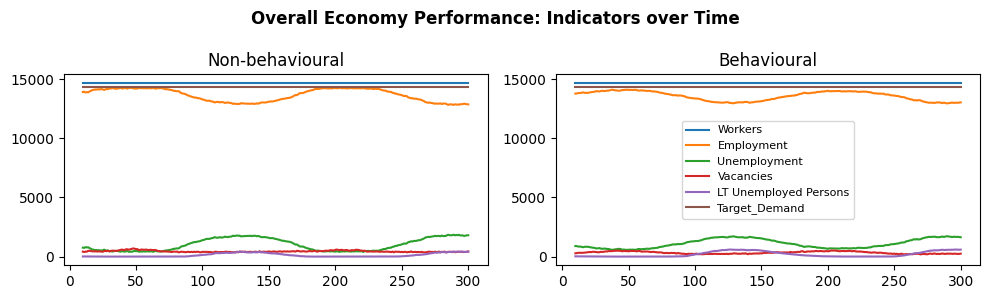

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

totals = record1_f.loc[10:,['Workers','Employment', 'Unemployment', 'Vacancies', 'LT Unemployed Persons', 'Target_Demand']]
lgd = []
for column in totals[1:]:
    ax1.plot(totals[column])
    lgd.append(column)
ax1.set_title("Non-behavioural")
    
totals = record1_t.loc[10:,['Workers','Employment', 'Unemployment', 'Vacancies', 'LT Unemployed Persons', 'Target_Demand']]
for column in totals[1:]:
    ax2.plot(totals[column])
ax2.set_title('Behavioural')

fig.suptitle("Overall Economy Performance: Indicators over Time", fontweight = 'bold')
plt.legend(list(lgd), loc="center", ncol=1, fontsize = 8)
fig.tight_layout()

if final:
    plt.savefig('../output/overall_economy_comparison_behav.jpg', dpi = 300)
else:
    plt.show()
plt.close()



## Unemployment and long-term unemployment rates

The below plots show the long-run behaviour of unemployment rate and long-term unemployment rate (defined as people unemployed for longer than 7 months). Both rates are slightly high for the US...the long-term unemployment rate (reported below as the proportion of unemployed workers in long-term unemployment) does look somewhat in line with observed real-world values (~15% of unemployed workers - with major fluctuations since the 2008 financial crisis, so might need to think a little more about what we want to target) in both models.  

This shoud look better if we move to calibrating unemployment rate to GDP.


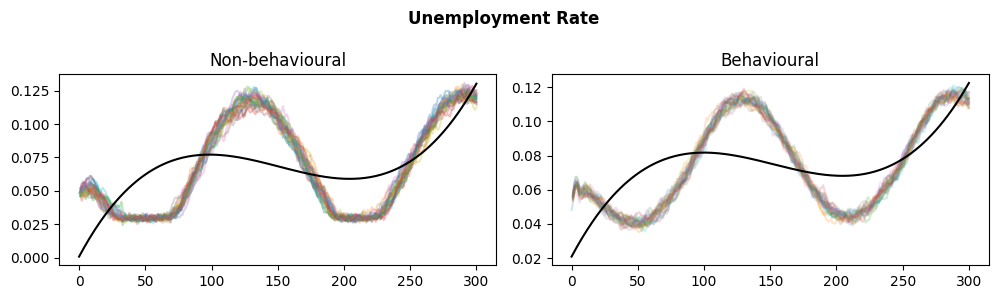

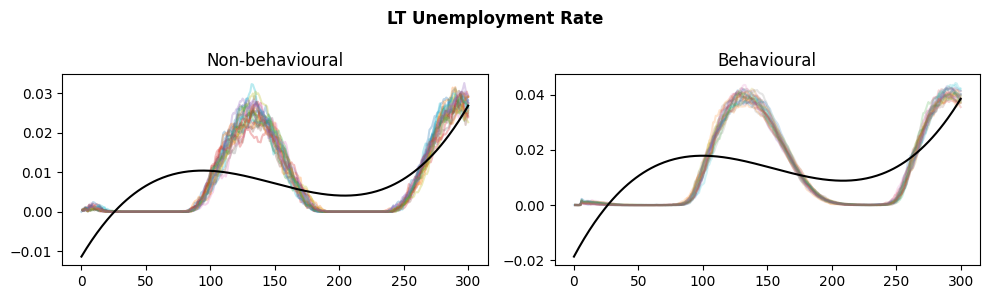

In [15]:
## Additional plotting code for when simluations - will need to modify array record to store results from multiple simulations

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

ltue_tot = sim_record_f.loc[:,['Sim','Time Step', 'Workers', 'Unemployment', 'LT Unemployed Persons']].groupby(['Time Step', 'Sim']).sum().reset_index()
ltue_tot['UE Rate'] = ltue_tot['Unemployment'] / ltue_tot['Workers']
ltue_tot['LTUE Rate'] = ltue_tot['LT Unemployed Persons'] / ltue_tot['Workers']
ltue_mean = ltue_tot.loc[:, ['Time Step', 'UE Rate']].groupby(['Time Step']).mean().reset_index()
spl = splrep(ltue_mean['Time Step'], ltue_mean['UE Rate'], s=2)
for g in np.unique(ltue_tot.Sim):
    temp = ltue_tot[(ltue_tot['Sim'] == g)][['UE Rate', 'Time Step']]
    ax1.plot(temp['Time Step'], temp['UE Rate'], alpha = 0.3)
    #temp = ltue_tot[(ltue_tot['Sim'] == g)][['UE Rate', 'Time']]
    #ax1.plot(temp['Time'], temp['UE Rate'])
ax1.plot(ltue_mean['Time Step'], BSpline(*spl)(ltue_mean['Time Step']), '-', label='s=0',  color = 'black')
ax1.set_title("Non-behavioural")
fig.suptitle("Unemployment Rate", fontweight = 'bold')


ltue_tot = sim_record_t.loc[:,['Sim','Time Step', 'Workers', 'Unemployment','LT Unemployed Persons']].groupby(['Time Step', 'Sim']).sum().reset_index()
ltue_tot['UE Rate'] = ltue_tot['Unemployment'] / ltue_tot['Workers']
ltue_tot['LTUE Rate'] = ltue_tot['LT Unemployed Persons'] / ltue_tot['Workers']
ltue_mean = ltue_tot.loc[:, ['Time Step', 'UE Rate']].groupby(['Time Step']).mean().reset_index()
spl = splrep(ltue_mean['Time Step'], ltue_mean['UE Rate'], s=2)
for g in np.unique(ltue_tot.Sim):
    temp = ltue_tot[(ltue_tot['Sim'] == g)][['UE Rate', 'Time Step']]
    ax2.plot(temp['Time Step'], temp['UE Rate'], alpha = 0.2)
    #temp = ltue_tot[(ltue_tot['Sim'] == g)][['UE Rate', 'Time']]
    #ax2.plot(temp['Time'], temp['UE Rate'])
ax2.plot(ltue_mean['Time Step'], BSpline(*spl)(ltue_mean['Time Step']), '-', label='s=0',  color = 'black')
ax2.set_title("Behavioural")
fig.suptitle("Unemployment Rate", fontweight = 'bold')
fig.tight_layout()

if final:
    plt.savefig('../output/ltuer_sim_comparison_behav.jpg', dpi = 300)
else:
    plt.show()
plt.close()

# INCLUDE WHEN DOING SIMULATIONS
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

ltue_tot = sim_record_f.loc[:,['Sim','Time Step', 'Workers', 'Unemployment', 'LT Unemployed Persons']].groupby(['Time Step', 'Sim']).sum().reset_index()
ltue_tot['UE Rate'] = ltue_tot['Unemployment'] / ltue_tot['Workers']
ltue_tot['LTUE Rate'] = ltue_tot['LT Unemployed Persons'] / ltue_tot['Workers']
ltue_mean = ltue_tot.loc[:, ['Time Step', 'LTUE Rate']].groupby(['Time Step']).mean().reset_index()
spl = splrep(ltue_mean['Time Step'], ltue_mean['LTUE Rate'], s=2)
for g in np.unique(ltue_tot.Sim):
    temp = ltue_tot[(ltue_tot['Sim'] == g)][['LTUE Rate', 'Time Step']]
    ax1.plot(temp['Time Step'], temp['LTUE Rate'], alpha = 0.3)
    #temp = ltue_tot[(ltue_tot['Sim'] == g)][['UE Rate', 'Time']]
    #ax1.plot(temp['Time'], temp['UE Rate'])
ax1.plot(ltue_mean['Time Step'], BSpline(*spl)(ltue_mean['Time Step']), '-', label='s=0',  color = 'black')
ax1.set_title("Non-behavioural")
fig.suptitle("LT Unemployment Rate", fontweight = 'bold')


ltue_tot = sim_record_t.loc[:,['Sim','Time Step', 'Workers', 'Unemployment','LT Unemployed Persons']].groupby(['Time Step', 'Sim']).sum().reset_index()
ltue_tot['UE Rate'] = ltue_tot['Unemployment'] / ltue_tot['Workers']
ltue_tot['LTUE Rate'] = ltue_tot['LT Unemployed Persons'] / ltue_tot['Workers']
ltue_mean = ltue_tot.loc[:, ['Time Step', 'LTUE Rate']].groupby(['Time Step']).mean().reset_index()
spl = splrep(ltue_mean['Time Step'], ltue_mean['LTUE Rate'], s=2)
for g in np.unique(ltue_tot.Sim):
    temp = ltue_tot[(ltue_tot['Sim'] == g)][['LTUE Rate', 'Time Step']]
    ax2.plot(temp['Time Step'], temp['LTUE Rate'], alpha = 0.2)
    #temp = ltue_tot[(ltue_tot['Sim'] == g)][['UE Rate', 'Time']]
    #ax2.plot(temp['Time'], temp['UE Rate'])
ax2.plot(ltue_mean['Time Step'], BSpline(*spl)(ltue_mean['Time Step']), '-', label='s=0',  color = 'black')
ax2.set_title("Behavioural")
fig.suptitle("LT Unemployment Rate", fontweight = 'bold')
fig.tight_layout()

if final:
    plt.savefig('../output/ltuer_sim_comparison_behav.jpg', dpi = 300)
else:
    plt.show()
plt.close()
